In [1]:
import sys
import os
sys.path.insert(0,'../classes')
sys.path.insert(0,'../analysis')
sys.path.insert(0,'/home/zz737/projects/fiar/cog_model/fourinarow/Analysis notebooks/new')
hqfd = '/home/zz737/projects/fiar/cog_model/fourinarow/Analysis notebooks/new/Heuristic quality'
sys.path.insert(0,hqfd)
from fourinarowfunctions import *
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import logging
import numpy as np

import coloredlogs

from arena import Arena
from coach import Coach
from beck.beck_game import BeckGame as Game
from beck.beck_nnet import NNetWrapper as nn
from beck.beck_players import HumanBeckPlayer
from mcts import MCTS
from utils import *
log = logging.getLogger(__name__)

from keras import backend as K

import tournament
# participant_iters = tournament.participant_iters

participants_dir = '/scratch/zz737/fiar/tournaments/tournament_4' # dir for trained networks
results_dir = '/scratch/zz737/fiar/tournaments/results/tournament_4'
moves_dir = '/scratch/zz737/fiar/tournaments/tournament_4/moves/raw/'
splits_dir = '/scratch/zz737/fiar/tournaments/tournament_4/moves/splits/'

import load, plot_fun, anl
from cog_related import cog_value_net as cvn
from importlib import reload
reload(load)

{'mcts100_cpuct1': [1, 2, 3, 4, 6, 7, 9, 11, 12, 16, 18, 21, 25, 28, 29, 30, 37, 38, 39, 45, 47], 'mcts100_cpuct2': [1, 2, 3, 4, 6, 8, 12, 14, 15, 16, 21, 22, 24, 26, 27, 30, 32, 35, 39], 'mcts100_cpuct3': [1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 12, 16, 17, 18, 20, 21, 25, 26, 28, 32, 34, 35, 36], 'mcts25_cpuct1': [1, 2, 3, 4, 9, 11, 13, 14, 16, 19, 22, 25, 28, 29, 31, 37, 39, 45, 59, 61], 'mcts50_cpuct1': [1, 2, 3, 4, 5, 6, 7, 9, 10, 13, 17, 18, 20, 21, 23, 25, 28, 29, 31, 37, 39, 41, 44, 45, 47, 48, 53], 'mcts80_cpuct1': [1, 2, 3, 4, 5, 7, 8, 9, 10, 13, 16, 19, 20, 21, 23, 24, 28, 34, 35, 36, 40], 'mcts80_cpuct2': [1, 2, 5, 6, 8, 10, 12, 13, 15, 17, 18, 19, 22, 25, 28, 30, 31, 34, 37, 38, 39, 40, 43, 45, 46, 51], 'mcts80_cpuct3': [1, 2, 5, 6, 7, 9, 12, 13, 14, 19, 21, 22, 23, 24, 26, 27, 28, 35, 36, 42, 43, 47, 49, 50, 51, 53, 54, 55, 56, 57]}
189 participant iterations!


<module 'load' from '../analysis/load.py'>

In [2]:
moves_dir_one_instance = os.path.join(moves_dir,'checkpoints_mcts100_cpuct2_id-3754964')
one_iter_csv = os.path.join(moves_dir_one_instance,'mcts100_cpuct2;13.csv')
one_iter_moves = pd.read_csv(one_iter_csv,sep=' ',header=None)
one_iter_moves.columns=['bp','wp','player','move','rt','iter','value']
one_iter_moves

,bp,wp,player,move,rt,iter,value
0,8192,0,white,4294967296,0,mcts100_cpuct2;13,-0.089887
1,4202496,4294967296,white,536870912,0,mcts100_cpuct2;13,0.146173
2,4202500,4831838208,white,1073741824,0,mcts100_cpuct2;13,-0.728382
3,4202508,5905580032,white,2147483648,0,mcts100_cpuct2;13,0.998833
4,8192,0,white,4194304,0,mcts100_cpuct2;13,-0.089887
...,...,...,...,...,...,...,...
11216,2147516416,12582912,black,16777216,0,mcts100_cpuct2;13,0.998374
11217,2164293632,4307550208,black,32,0,mcts100_cpuct2;13,0.997159
11218,2164293664,4307550224,black,8192,0,mcts100_cpuct2;13,0.873308
11219,2164301856,4307554320,black,4,0,mcts100_cpuct2;13,0.059626


In [3]:
g = Game(4, 9, 4)
inv_d = cvn.get_inv_dist_to_center(g)

In [5]:
import value_analysis as va
import importlib
importlib.reload(va)

<module 'value_analysis' from '../analysis/value_analysis.py'>

In [6]:
moves_dir_one_instance

'/scratch/zz737/fiar/tournaments/tournament_4/moves/raw/checkpoints_mcts100_cpuct2_id-3754964'

In [7]:
moves_dir_one_instance = os.path.join(moves_dir,'checkpoints_mcts100_cpuct2_id-3754964')
iter_csv = 'mcts100_cpuct2;50.csv'
one_iter_feats = va.load_moves_get_features(moves_dir_one_instance,iter_csv,epsilon=1e-8)

INFO: Pandarallel will run on 48 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [52]:
ntot = len(one_iter_feats)
chosen_inds = np.random.choice(np.arange(ntot),size=int(ntot*4/5))

In [8]:
path = '/scratch/zz737/fiar/tournaments/tournament_4/moves/feat_w_from_value_fit/checkpoints_mcts100_cpuct2_id-3754964'
path = os.path.join(path,iter_csv)

In [53]:
chosen_inds

array([ 396, 5160, 3338, ..., 6113, 2931, 1368])

In [9]:
one_iter_feats

,self_center,self_2_con,self_2_uncon,self_3,oppo_center,oppo_2_con,oppo_2_uncon,oppo_3,value,value_logit
0,0.000000,0.0,0.0,0.0,2.000000,0.0,0.0,0.0,0.441864,-0.233598
1,0.666667,0.0,0.0,0.0,2.400000,0.0,1.0,0.0,0.335173,-0.684880
2,2.666667,0.0,0.0,0.0,3.066667,0.0,1.0,0.0,0.349016,-0.623367
3,3.561094,4.0,0.0,0.0,3.466667,0.0,3.0,0.0,0.901875,2.218234
4,4.046165,3.0,0.0,2.0,4.021367,2.0,1.0,1.0,0.999879,9.019599
...,...,...,...,...,...,...,...,...,...,...
9794,8.227325,0.0,0.0,0.0,7.403802,1.0,0.0,1.0,0.487122,-0.051523
9795,8.556123,1.0,0.0,0.0,7.958502,0.0,0.0,1.0,0.504348,0.017392
9796,8.790205,0.0,0.0,0.0,8.206572,0.0,0.0,0.0,0.514496,0.058000
9797,9.684632,0.0,0.0,0.0,8.691643,0.0,0.0,0.0,0.509967,0.039873


In [122]:
res,res_df=va.regression(one_iter_feats,path=path)
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:            value_logit   R-squared (uncentered):                   0.333
Model:                            OLS   Adj. R-squared (uncentered):              0.332
Method:                 Least Squares   F-statistic:                              611.1
Date:                Thu, 10 Jun 2021   Prob (F-statistic):                        0.00
Time:                        17:01:11   Log-Likelihood:                         -11919.
No. Observations:                9799   AIC:                                  2.385e+04
Df Residuals:                    9791   BIC:                                  2.391e+04
Df Model:                           8                                                  
Covariance Type:            nonrobust                                                  
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
self_center     -0.0110      0.021     -0.533      0.594      -0.051       0.029
self_2_con       0.1535      0.011     13.827      0.000       0.132       0.175
self_2_uncon     0.0919      0.009     10.118      0.000       0.074       0.110
self_3           0.4996      0.009     58.762      0.000       0.483       0.516
oppo_center      0.0718      0.021      3.374      0.001       0.030       0.114
oppo_2_con       0.2155      0.009     23.739      0.000       0.198       0.233
oppo_2_uncon     0.0135      0.009      1.499      0.134      -0.004       0.031
oppo_3          -0.2319      0.012    -19.513      0.000      -0.255      -0.209
==============================================================================
Omnibus:                    12727.148   Durbin-Watson:                   0.807
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          3102890.469
Skew:                           7.188   Prob(JB):                         0.00
Kurtosis:                      88.983   Cond. No.                         5.20
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

(<Figure size 432x288 with 1 Axes>, <AxesSubplot:>)

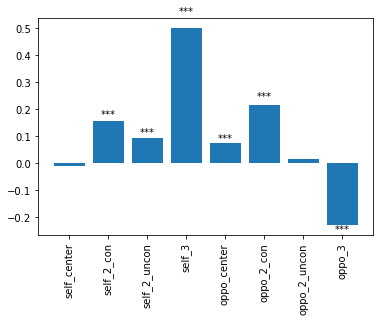

In [123]:
pf.plot_regression_coef(res)

In [114]:
moves_dir_one_instance = os.path.join(moves_dir,'checkpoints_mcts100_cpuct2_id-3754964')
iter_csv = 'mcts100_cpuct2;13.csv'
one_iter_feats = va.load_moves_get_features(moves_dir_one_instance,iter_csv,epsilon=1e-8)

INFO: Pandarallel will run on 48 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [115]:
res,res_df=va.regression(one_iter_feats)
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:            value_logit   R-squared (uncentered):                   0.325
Model:                            OLS   Adj. R-squared (uncentered):              0.324
Method:                 Least Squares   F-statistic:                              673.5
Date:                Thu, 10 Jun 2021   Prob (F-statistic):                        0.00
Time:                        16:57:37   Log-Likelihood:                         -13720.
No. Observations:               11221   AIC:                                  2.746e+04
Df Residuals:                   11213   BIC:                                  2.751e+04
Df Model:                           8                                                  
Covariance Type:            nonrobust                                                  
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
self_center     -0.4701      0.015    -31.753      0.000      -0.499      -0.441
self_2_con       0.2500      0.010     24.597      0.000       0.230       0.270
self_2_uncon    -0.0062      0.010     -0.594      0.553      -0.027       0.014
self_3           0.3567      0.008     45.351      0.000       0.341       0.372
oppo_center      0.2956      0.015     19.939      0.000       0.267       0.325
oppo_2_con       0.0035      0.008      0.433      0.665      -0.012       0.020
oppo_2_uncon     0.1072      0.008     12.706      0.000       0.091       0.124
oppo_3          -0.4100      0.012    -34.194      0.000      -0.434      -0.387
==============================================================================
Omnibus:                      678.708   Durbin-Watson:                   1.186
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1349.769
Skew:                           0.429   Prob(JB):                    7.97e-294
Kurtosis:                       4.466   Cond. No.                         4.36
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [119]:
import plot_fun as pf
importlib.reload(pf)

<module 'plot_fun' from '../analysis/plot_fun.py'>

(<Figure size 432x288 with 1 Axes>, <AxesSubplot:>)

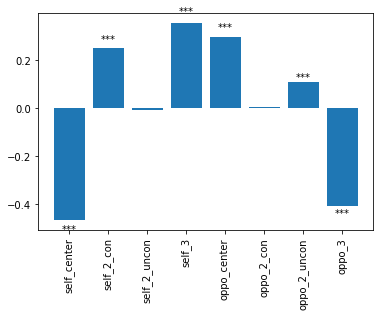

In [120]:
pf.plot_regression_coef(res)

In [10]:
path = '/scratch/zz737/fiar/tournaments/tournament_4/moves/feat_w_from_value_fit/checkpoints_mcts100_cpuct2_id-3754964'

In [86]:
def read_reg_res_iters_in_dir(path):
    reg_res_l = {}
    for f in os.listdir(path):
        fn = os.path.join(path,f)
        reg_res= pd.read_csv(fn,index_col=0)
        reg_res = reg_res.unstack()
        iter = int(f.split(';')[1].split('.')[0])
        reg_res['iter'] = iter
        reg_res_l[f] = reg_res
    reg_res_l = pd.DataFrame(reg_res_l).T
    reg_res_l = reg_res_l.sort_values('iter')

    feat_keys = reg_res_l.columns.get_level_values(1).unique()
    feat_keys = feat_keys.drop('')

    feat_keys_general = list(set([k[5:] for k in feat_keys]))
    return reg_res_l, feat_keys_general

Text(0.5, 1.0, 'r2')

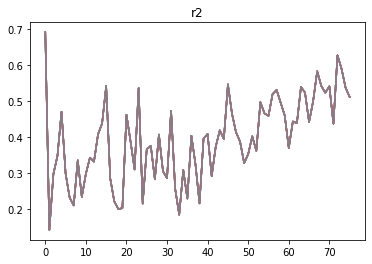

In [79]:
plt.figure()
plt.plot(reg_res_l['r2'].values)
plt.title('r2')

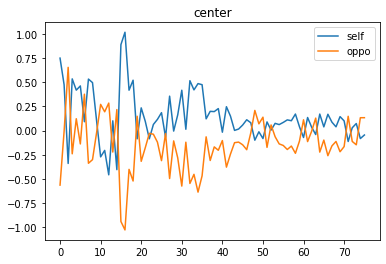

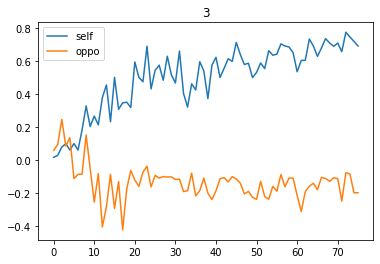

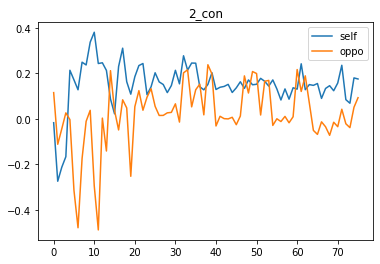

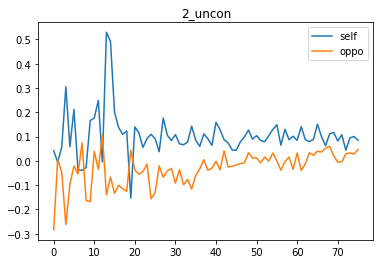

In [77]:
for k in feat_keys_general:
    plt.figure()
    plt.plot(reg_res_l[('coeff','self_'+k)].values,label='self')
    plt.plot(reg_res_l[('coeff','oppo_'+k)].values,label='oppo')
    plt.title(k)
    plt.legend()

In [87]:
path = '/scratch/zz737/fiar/tournaments/tournament_4/moves/feat_w_from_value_fit/checkpoints_mcts100_cpuct2_id-3752918'

In [88]:
reg_res_l_new, feat_keys_general = read_reg_res_iters_in_dir(path)

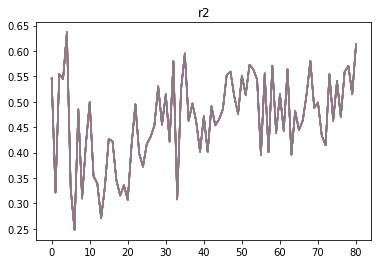

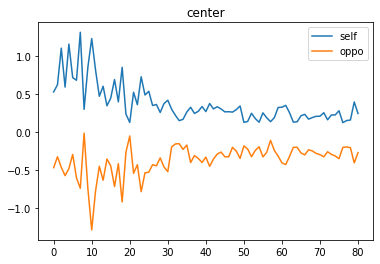

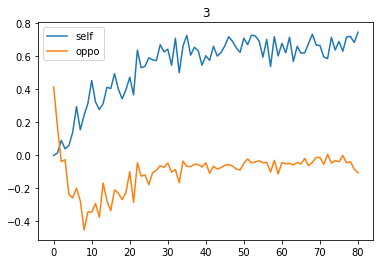

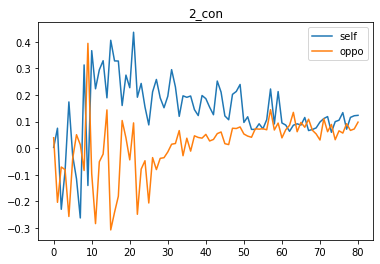

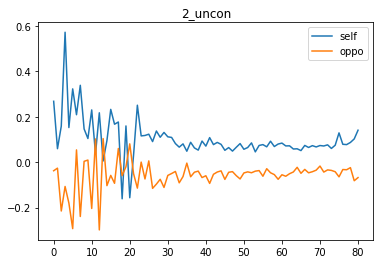

In [89]:
plt.figure()
plt.plot(reg_res_l_new['r2'].values)
plt.title('r2')

for k in feat_keys_general:
    plt.figure()
    plt.plot(reg_res_l_new[('coeff','self_'+k)].values,label='self')
    plt.plot(reg_res_l_new[('coeff','oppo_'+k)].values,label='oppo')
    plt.title(k)
    plt.legend()